## Normalization example

expanded on https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html#real-world-data-set

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.datasets import load_boston
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
# `normed` is being deprecated in favor of `density` in histograms
if LooseVersion(matplotlib.__version__) >= '2.1':
    density_param = {'density': True}
else:
    density_param = {'normed': True}

## Load dataset

In [3]:
dataset = load_boston()
from IPython.display import display, Markdown
display(Markdown(dataset['DESCR']))

target = np.array(dataset.feature_names) == "DIS"
X = dataset.data[:, np.logical_not(target)]
y = dataset.data[:, target].squeeze()
y_trans = quantile_transform(
    dataset.data[:, target],
    n_quantiles=300,
    output_distribution='normal',
    copy=True
).squeeze()


.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/


This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.


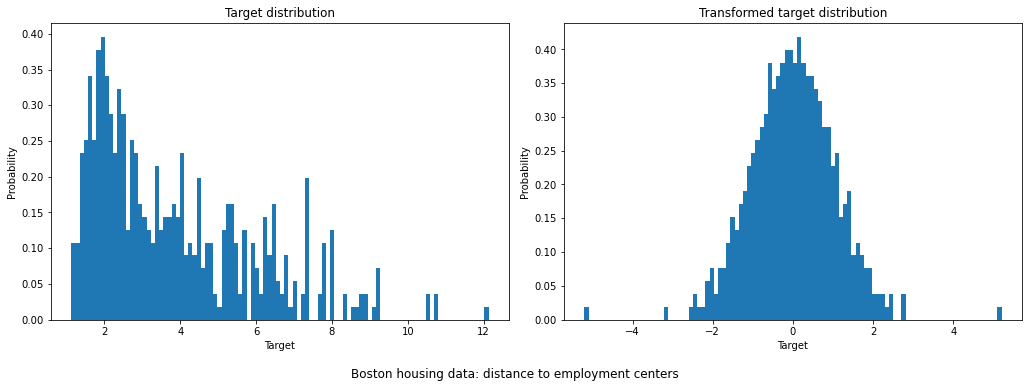

In [4]:

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 6))

ax0.hist(y, bins=100, **density_param)
ax0.set_ylabel('Probability')
ax0.set_xlabel('Target')
ax0.set_title('Target distribution')

ax1.hist(y_trans, bins=100, **density_param)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Target')
ax1.set_title('Transformed target distribution')

f.suptitle("Boston housing data: distance to employment centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


## Create baseline

In [5]:
regr = RidgeCV()
regr.fit(X_train, y_train)
y_pred_baseline = regr.predict(X_test)

## Do grid search

In [6]:
# Create a pipeline
pipe = Pipeline([('feature_selection', SelectFromModel(ExtraTreesRegressor())),
                 ('regressor', TransformedTargetRegressor(
                                    regressor=RidgeCV(),
                                    transformer=QuantileTransformer(n_quantiles=300,
                                                                    output_distribution='normal'))),
                 
                ])

# Create space of candidate learning algorithms and their hyperparameters
search_space = [
                {
                    'regressor__regressor': [RandomForestRegressor()],
                    'regressor__regressor__n_estimators': [10, 100, 1000]
                },
                {
                    'regressor__regressor': [Ridge()]
                },
                {
                    'regressor__regressor': [KNeighborsRegressor()],
                    'regressor__regressor__n_neighbors': range(2,8)
                }
               ]

# Create grid search 
clf = GridSearchCV(pipe, search_space, scoring='neg_mean_absolute_error', cv=5, verbose=0)


# Fit grid search
best_model = clf.fit(X_train, y_train)

In [7]:
best_model.best_estimator_['regressor'].regressor

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [8]:
y_pred = best_model.predict(X_test)

## Check if gridsearch had improvement

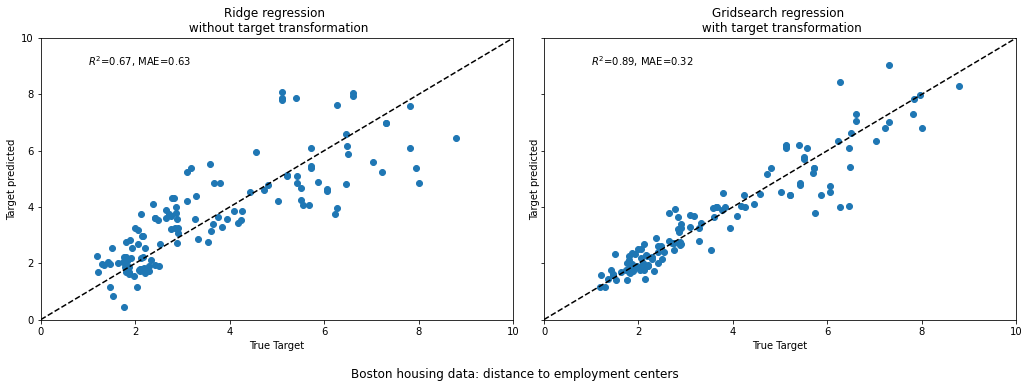

In [9]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(16, 6))

ax0.scatter(y_test, y_pred_baseline)
ax0.plot([0, 10], [0, 10], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(1, 9, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred_baseline), median_absolute_error(y_test, y_pred_baseline)))
ax0.set_xlim([0, 10])
ax0.set_ylim([0, 10])

ax1.scatter(y_test, y_pred)
ax1.plot([0, 10], [0, 10], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Gridsearch regression \n with target transformation')
ax1.text(1, 9, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test, y_pred), median_absolute_error(y_test, y_pred)))
ax1.set_xlim([0, 10])
ax1.set_ylim([0, 10])

f.suptitle("Boston housing data: distance to employment centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()

## Save model

We can save our best model, which also contains the feature selection step and the normalization/denormalization, so users of the model do not have to know any specifics.

In [10]:
from waylay import WaylayClient, RestResponseError
waylay = WaylayClient.from_profile()

In [11]:
model_name = 'sklearn-demo'
model_description = """
A model to predict the weighted distance to five Boston employment centers, 
using the following features: 
 - CRIM per capita crime rate by town,
 - ZN proportion of residential land zoned for lots over 25,000 sq.ft.
 - INDUS proportion of non-retail business acres per town,
 - CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise),
 - NOX nitric oxides concentration (parts per 10 million)RM average number of rooms per dwelling,
 - AGE proportion of owner-occupied units built prior to 1940,
 - DIS weighted distances to five Boston employment centres,
 - RAD index of accessibility to radial highways,
 - TAX full-value property-tax rate per $10,000,
 - PTRATIO pupil-teacher ratio by town,
 - B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town,
 - LSTAT % lower status of the population.
 - MEDV Median value of owner-occupied homes in $1000's
"""
try:
    waylay.byoml.model.remove(model_name)
except RestResponseError as e:
    display(f'Ignored: {e}')

"Ignored: ByomlActionError(404: 'Model does not exist'; DELETE 'https://byoml-io.waylay.io/models/sklearn-demo')"

In [12]:
waylay.byoml.model.upload(
    model_name=model_name, 
    trained_model=best_model, 
    framework='sklearn', 
    description=model_description
)

{'message': 'Model successfully uploaded'}

In [13]:
waylay.byoml.model.get(model_name)

{'createdBy': 'users/bd87db46-e8fc-4186-bdf4-a8f9478ed0d3',
 'createdOn': '2021-06-02T15:02:40.166751+00:00',
 'description': "\nA model to predict the weighted distance to five Boston employment centers, \nusing the following features: \n - CRIM per capita crime rate by town,\n - ZN proportion of residential land zoned for lots over 25,000 sq.ft.\n - INDUS proportion of non-retail business acres per town,\n - CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise),\n - NOX nitric oxides concentration (parts per 10 million)RM average number of rooms per dwelling,\n - AGE proportion of owner-occupied units built prior to 1940,\n - DIS weighted distances to five Boston employment centres,\n - RAD index of accessibility to radial highways,\n - TAX full-value property-tax rate per $10,000,\n - PTRATIO pupil-teacher ratio by town,\n - B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town,\n - LSTAT % lower status of the population.\n - MEDV Median value of owne

## Check if upload worked

In [14]:
best_model.predict(X_test[:2])

array([3.67346042, 3.80175379])

In [15]:
result = waylay.byoml.model.predict(model_name, X)

import pandas as pd
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['prediction'] = result
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,prediction
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,4.084168
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,4.532093
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,4.727614
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,5.173183
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,4.752268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,2.597280
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,2.416529
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,2.287330
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,2.141162


<AxesSubplot:xlabel='DIS', ylabel='prediction'>

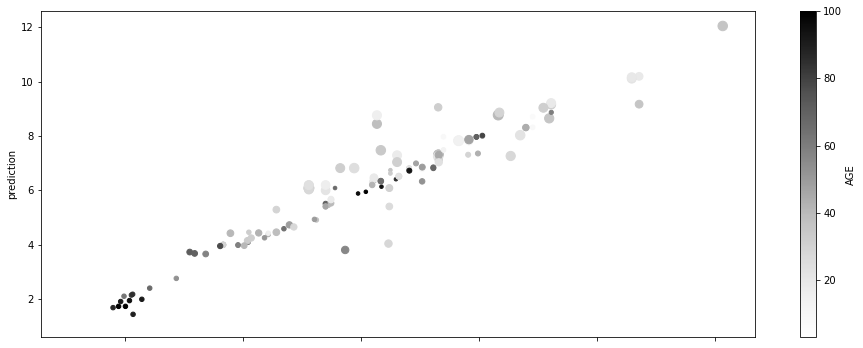

In [16]:
df.plot.scatter( x="DIS", y='prediction', s='ZN', c='AGE', figsize=(16, 6))

## Cleanup

In [17]:
waylay.byoml.model.remove(model_name)

{'message': 'Model successfully deleted'}